# Combining IMDB and RT Reviews of Star Wars: The Last Jedi

Here I'll be merging together datasets of reviews from imdb and rotten tomatoes.

In [1]:
import numpy as np
import pandas as pd

import os, re

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
imdb_data = pd.read_csv("../data/imdb_data.csv")
rt_data_1 = pd.read_csv("../rotten_tomatoes/reviews.csv")
rt_data_2 = pd.read_csv("../rotten_tomatoes/reviews.csv")

rt_data = pd.concat([rt_data_1, rt_data_2]).drop_duplicates()

imdb_data['star_rating'] = imdb_data.star_rating / 2
imdb_data['source'] = 'imdb'
rt_data['source'] = 'rotten tomatoes'

data_cols = ['date', 'name', 'user_link', 'source', 'review', 'downvotes', 'upvotes', 'star_rating']
review_data = pd.concat([imdb_data, rt_data])[data_cols]

source
imdb               AxesSubplot(0.125,0.125;0.775x0.755)
rotten tomatoes    AxesSubplot(0.125,0.125;0.775x0.755)
Name: star_rating, dtype: object

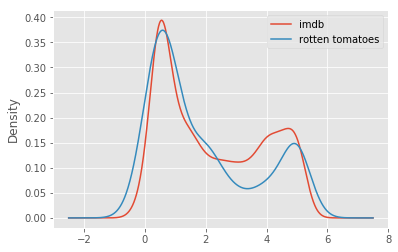

In [3]:
(review_data
     .groupby('source')
     ['star_rating']
     .plot(kind = 'density', legend = True))

Average score: 2.18 out of 5


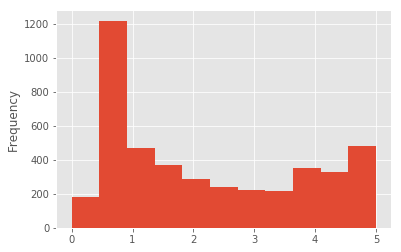

In [4]:
print("Average score: %.2f out of 5" %review_data.star_rating.mean())
review_data.star_rating.plot(kind = 'hist', bins = 11)

In [5]:
review_data.head()

,date,name,user_link,source,review,downvotes,upvotes,star_rating
0,10 December 2017,Michael Anietie Asuquo,http://www.imdb.com/user/ur63609896/?ref_=tt_urv,imdb,"For film fanatics like myself, The Last Jedi i...",194.0,138.0,4.0
1,10 December 2017,smg242,http://www.imdb.com/user/ur46304483/?ref_=tt_urv,imdb,"First of all, let me alleviate the concern tha...",170.0,105.0,5.0
2,10 December 2017,kashidomar,http://www.imdb.com/user/ur65211374/?ref_=tt_urv,imdb,From all aspect this is by far the most attrac...,218.0,119.0,5.0
3,11 December 2017,Nick Gargas (dirty_chords),http://www.imdb.com/user/ur44721165/?ref_=tt_urv,imdb,I attended an advanced press screening of the ...,142.0,93.0,4.0
4,12 December 2017,OneEightNine Media,http://www.imdb.com/user/ur52600820/?ref_=tt_urv,imdb,I am giving this movie 7.4 out of 10 stars but...,88.0,53.0,2.5


## Analysing Reviews in Spacy

In [14]:
import spacy
from spacy import displacy

import itertools as it

In [7]:
nlp = spacy.load('en')

In [8]:
nlp_reviews = list(nlp.pipe(review_data.review, n_threads = 4))

In [9]:
parsed_review = nlp_reviews[0]

In [27]:
i = 0
for review in nlp_reviews:
    for num, entity in enumerate(review.ents):
        print('Entity {}:'.format(num + 1), entity, '-', entity.label_)
        
        i += 1
        if i >= 20:
            break
    if i >= 20:
        break

Entity 1: Star Wars - WORK_OF_ART
Entity 2: this 2 and a half hour - TIME
Entity 3: The Last Jedi - PRODUCT
Entity 4: first - ORDINAL
Entity 5: Rey - PERSON
Entity 6: Kylo - GPE
Entity 7: Luke - PERSON
Entity 8: years - DATE
Entity 9: Kylo - GPE
Entity 10: Finn - PERSON
Entity 11: Poe - PERSON
Entity 12: Adam Driver - PERSON
Entity 13: Snoke - PERSON
Entity 14: Mark Hamill - PERSON
Entity 15: one - CARDINAL
Entity 16: Andy Serkis - PERSON
Entity 17: Oscar Isaac - PERSON
Entity 18: Gwendoline Christie - PERSON
Entity 19: Sci-Fi - PERSON
Entity 20: Star Wars - ORG


In [28]:
token_text = [token.orth_ for token in parsed_review]
token_pos = [token.pos_ for token in parsed_review]

pd.DataFrame(list(zip(token_text, token_pos)),
             columns=['token_text', 'part_of_speech']).head(10)

,token_text,part_of_speech
0,For,ADP
1,film,NOUN
2,fanatics,NOUN
3,like,ADP
4,myself,PRON
5,",",PUNCT
6,The,DET
7,Last,ADJ
8,Jedi,PROPN
9,is,VERB


In [29]:
token_lemma = [token.lemma_ for token in parsed_review]
token_shape = [token.shape_ for token in parsed_review]

pd.DataFrame(list(zip(token_text, token_lemma, token_shape)),
             columns=['token_text', 'token_lemma', 'token_shape']).head(10)

,token_text,token_lemma,token_shape
0,For,for,Xxx
1,film,film,xxxx
2,fanatics,fanatic,xxxx
3,like,like,xxxx
4,myself,-PRON-,xxxx
5,",",",",","
6,The,the,Xxx
7,Last,last,Xxxx
8,Jedi,jedi,Xxxx
9,is,be,xx


In [30]:
token_entity_type = [token.ent_type_ for token in parsed_review]
token_entity_iob = [token.ent_iob_ for token in parsed_review]

pd.DataFrame(list(zip(token_text, token_entity_type, token_entity_iob)),
             columns=['token_text', 'entity_type', 'inside_outside_begin']).head(10)

,token_text,entity_type,inside_outside_begin
0,For,,O
1,film,,O
2,fanatics,,O
3,like,,O
4,myself,,O
5,",",,O
6,The,,O
7,Last,,O
8,Jedi,,O
9,is,,O


In [31]:
token_attributes = [(token.orth_,
                     token.prob,
                     token.is_stop,
                     token.is_punct,
                     token.is_space,
                     token.like_num,
                     token.is_oov)
                    for token in parsed_review]

df = pd.DataFrame(token_attributes,
                  columns=['text',
                           'log_probability',
                           'stop?',
                           'punctuation?',
                           'whitespace?',
                           'number?',
                           'out of vocab.?'])

df.loc[:, 'stop?':'out of vocab.?'] = (df.loc[:, 'stop?':'out of vocab.?']
                                         .applymap(lambda x: u'Yes' if x else u''))
                                               
df.head(10)

,text,log_probability,stop?,punctuation?,whitespace?,number?,out of vocab.?
0,For,-20.0,,,,,Yes
1,film,-20.0,,,,,Yes
2,fanatics,-20.0,,,,,Yes
3,like,-20.0,,,,,Yes
4,myself,-20.0,Yes,,,,Yes
5,",",-20.0,,Yes,,,Yes
6,The,-20.0,,,,,Yes
7,Last,-20.0,,,,,Yes
8,Jedi,-20.0,,,,,Yes
9,is,-20.0,Yes,,,,Yes


In [32]:
review_data.source.value_counts()

imdb               3683
rotten tomatoes     685
Name: source, dtype: int64

In [33]:
review_data.name

0          Michael Anietie Asuquo
1                          smg242
2                      kashidomar
3      Nick Gargas (dirty_chords)
4              OneEightNine Media
5              www.ramascreen.com
6                 shawneofthedead
7                  frankvdh-75554
8                        orkunust
9                   realyogsototh
10               cyberjoshy-49579
11                     djomladinr
12                     kamenhaven
13                         averst
14                  Frank_Caprica
15                         llepen
16              guillaume-buisson
17                        panlasa
18                    marioderekx
19                     darthmoonx
20          matt-turner-98-577296
21              pensacolacomputer
22                     Adam Sipos
23                      cgifford6
24                       degothia
25                     Enes Tamer
26             soerenmeierwissing
27                  bjornskoglund
28                     seadsead86
29            

## Phrase Modelling

In [34]:
import itertools as it
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

c:\users\caleb\anaconda3\envs\spacy-env\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [35]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

def line_review(text):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    
    return review.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(reviews):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for parsed_review in reviews:
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

In [36]:
model_dir = "../data/models"
run_model = True

In [37]:
unigram_sentences_filepath = os.path.join(model_dir, 'unigram_sentences_all.txt')

In [38]:
%%time
if run_model:
    # this is a bit time consuming - make the if statement True
    # if you want to execute data prep yourself.
    with open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus(nlp_reviews):
            f.write(sentence + '\n')

Wall time: 2.1 s


In [39]:
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [40]:
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print(u' '.join(unigram_sentence))
    print(u'')

-PRON- also enjoy some action and special effect which be generally quite pleasing

but there be very good occasion to make a great movie and all of -PRON- be lose so in the end that be not a movie

-PRON- think -PRON- will remember

so if -PRON- be ok to look at a disney movie go for -PRON- -PRON- will be happy

if -PRON- want to watch a star wars movie ã la rogue one

then -PRON- better not watch this movie

-PRON- just get back after watch the last jedi and i still do not really know if i find this movie good or bad

first the thing i like

the space battle look amazing

the lightsaber battle be very well donei like the character rey much more this time i hat -PRON- in tfa



In [41]:
bigram_model_filepath = os.path.join(model_dir, 'bigram_model_all.gensim')

In [42]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute modeling yourself.
if run_model:

    bigram_model = Phrases(unigram_sentences)

    bigram_model.save(bigram_model_filepath)
    
# load the finished model from disk
bigram_model = Phrases.load(bigram_model_filepath)

Wall time: 4.13 s


In [44]:
bigram_sentences_filepath = os.path.join(model_dir, 'bigram_sentences_all.txt')

In [45]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if run_model:

    with open(bigram_sentences_filepath, 'w', encoding='utf_8') as f:
        
        for unigram_sentence in unigram_sentences:
            
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            
            f.write(bigram_sentence + '\n')

c:\users\caleb\anaconda3\envs\spacy-env\lib\site-packages\gensim\models\phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Wall time: 7.37 s


In [46]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [47]:
for bigram_sentence in it.islice(bigram_sentences, 230, 240):
    print(' '.join(bigram_sentence))
    print('')

-PRON- also enjoy some action and special_effect which be generally quite pleasing

but there be very good occasion to make a great movie and all of -PRON- be lose so in the end that be not a movie

-PRON- think -PRON- will remember

so if -PRON- be ok to look at a disney movie go for -PRON- -PRON- will be happy

if -PRON- want to watch a star_wars movie ã la rogue_one

then -PRON- better not watch this movie

-PRON- just get back after watch the last_jedi and i still do not really know if i find this movie good or bad

first the thing i like

the space_battle look amazing

the lightsaber_battle be very well donei like the character rey much more this time i hat -PRON- in tfa



In [48]:
trigram_model_filepath = os.path.join(model_dir, 'trigram_model_all')

In [49]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute modeling yourself.
if run_model:

    trigram_model = Phrases(bigram_sentences)

    trigram_model.save(trigram_model_filepath)
    
# load the finished model from disk
trigram_model = Phrases.load(trigram_model_filepath)

Wall time: 3.85 s


In [50]:
trigram_sentences_filepath = os.path.join(model_dir, 'trigram_sentences_all.txt')

In [51]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if run_model:

    with open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
        
        for bigram_sentence in bigram_sentences:
            
            trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            
            f.write(trigram_sentence + '\n')

c:\users\caleb\anaconda3\envs\spacy-env\lib\site-packages\gensim\models\phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Wall time: 7.25 s


In [52]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [53]:
for trigram_sentence in it.islice(trigram_sentences, 230, 240):
    print(' '.join(trigram_sentence))
    print(u'')

-PRON- also enjoy some action and special_effect which be generally quite pleasing

but there be very good occasion to make a great movie and all of -PRON- be lose so in the end that be not a movie

-PRON- think -PRON- will remember

so if -PRON- be ok to look_at a disney movie go for -PRON- -PRON- will be happy

if -PRON- want to watch a star_wars movie ã la rogue_one

then -PRON- better not watch this movie

-PRON- just get back after watch the last_jedi and i still do not really know if i find this movie good or bad

first the thing i like

the space_battle look amazing

the lightsaber_battle be very well donei like the character rey much_more this time i hat -PRON- in tfa



In [54]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
import pickle

In [57]:
trigram_dictionary_filepath = os.path.join(model_dir, 'trigram_dict_all.dict')
trigram_reviews_filepath = os.path.join(model_dir, 'trigram_review_all.txt')

In [56]:
from nltk.corpus import stopwords

In [58]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if run_model:

    with open(trigram_reviews_filepath, 'w', encoding='utf_8') as f:
        
        for i, parsed_review in enumerate(nlp_reviews):
            
            # lemmatize the text, removing punctuation and whitespace
            unigram_review = [token.lemma_ for token in parsed_review
                              if not punct_space(token)]
            
            # apply the first-order and second-order phrase models
            bigram_review = bigram_model[unigram_review]
            trigram_review = trigram_model[bigram_review]
            
            # remove any remaining stopwords
            trigram_review = [term for term in trigram_review
                              if term not in stopwords.words("english")]
            
            # write the transformed review as a line in the new file
            trigram_review = u' '.join(trigram_review)
            f.write(trigram_review + '\n')

c:\users\caleb\anaconda3\envs\spacy-env\lib\site-packages\gensim\models\phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Wall time: 5min 51s


In [59]:
# this is a bit time consuming - make the if statement True
# if you want to learn the dictionary yourself.
if run_model:
    
    trigram_reviews = LineSentence(trigram_reviews_filepath)
    
    # learn the dictionary by iterating over all of the reviews
    trigram_dictionary = Dictionary(trigram_reviews)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
    trigram_dictionary.compactify()
        
    trigram_dictionary.save(trigram_dictionary_filepath)
    
# load the finished dictionary from disk
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

In [60]:
trigram_reviews_filepath = os.path.join(model_dir, 'trigram_transformed_reviews_all.txt')

In [61]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if run_model:

    with open(trigram_reviews_filepath, 'w', encoding='utf_8') as f:
        
        for parsed_review in nlp_reviews:
            
            # lemmatize the text, removing punctuation and whitespace
            unigram_review = [token.lemma_ for token in parsed_review
                              if not punct_space(token)]
            
            # apply the first-order and second-order phrase models
            bigram_review = bigram_model[unigram_review]
            trigram_review = trigram_model[bigram_review]
            
            # remove any remaining stopwords
            trigram_review = [term for term in trigram_review
                              if term not in stopwords.words('english')]
            
            # write the transformed review as a line in the new file
            trigram_review = u' '.join(trigram_review)
            f.write(trigram_review + '\n')

c:\users\caleb\anaconda3\envs\spacy-env\lib\site-packages\gensim\models\phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Wall time: 5min 56s


In [44]:
print(u'Original:' + u'\n')

for review in it.islice(nlp_reviews, 11, 12):
    print(review)

print(u'----' + u'\n')
print(u'Transformed:' + u'\n')

with open(trigram_reviews_filepath, encoding='utf_8') as f:
    for review in it.islice(f, 11, 12):
        print(review)

Original:

First of all, big fan of Star Wars.
But this just killed the whole saga... Compared to this, Rogue One is a proper masterpeace. People wold think that they have learned from the Episode 7 disaster. Going to the theather my only Hope (pun intended), was that it wont be that bad. It was worse... Way, way worse.
 There where actualy people leaving the cinema. That has to tell you something. 
Sentences from the original saga like: Join me, and together we shall rule the galaxy, and Youre are fulfiling youre destiny just killed it.
Battle of Hoth, Falcon run into the Death Star and the rest of the bad ripoffs are killing the whole movie. 
Whoever is a SW fan and gave this movie more than 3 is payed to write good about it.
----

Transformed:

first big fan star_wars kill whole saga compare rogue_one proper masterpeace people wold think -PRON- learn episode_7 disaster go theather -PRON- hope pun_intend -PRON- bad -PRON- bad way way bad actualy people leave cinema tell -PRON- someth

## Modelling with Latent Dirichlet Allocation (LDA)

In [45]:
def lda_description(parsed_review, min_topic_freq=0.05):
    """
    accept the original text of a review and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a sorted list of the top topics in the LDA representation
    """
    
    # lemmatize the text and remove punctuation and whitespace
    unigram_review = [token.lemma_ for token in parsed_review
                      if not punct_space(token)]
    
    # apply the first-order and secord-order phrase models
    bigram_review = bigram_model[unigram_review]
    trigram_review = trigram_model[bigram_review]
    
    # remove any remaining stopwords
    trigram_review = [term for term in trigram_review
                      if not term in stopwords.words('english')]
    
    # create a bag-of-words representation
    review_bow = trigram_dictionary.doc2bow(trigram_review)
    
    # create an LDA representation
    review_lda = lda[review_bow]
    
    # sort with the most highly related topics first
    review_lda = sorted(review_lda, key=lambda topic_number, freq: -freq)
    
    for topic_number, freq in review_lda:
        if freq < min_topic_freq:
            break
            
        # print the most highly related topic names and frequencies
        print('{:25} {}'.format(topic_names[topic_number], round(freq, 3)))

In [46]:
def trigram_bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    
    for review in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(review)

In [47]:
%%time

trigram_bow_filepath = os.path.join(model_dir, 'trigram_bow_corpus_all.mm')

# this is a bit time consuming - make the if statement True
# if you want to build the bag-of-words corpus yourself.
if run_model:

    # generate bag-of-words representations for
    # all reviews and save them as a matrix
    MmCorpus.serialize(trigram_bow_filepath,
                       trigram_bow_generator(trigram_reviews_filepath))
    
# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

Wall time: 1.99 s


In [48]:
%%time

lda_model_filepath = os.path.join(model_dir, 'lda_model_all')

# this is a bit time consuming - make the if statement True
# if you want to train the LDA model yourself.
if run_model:

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=10,
                           id2word=trigram_dictionary,
                           workers=3)
    
    lda.save(lda_model_filepath)
    
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

Wall time: 11.6 s


In [49]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [50]:
LDAvis_data_filepath = os.path.join(model_dir, 'ldavis_prepared')

In [51]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if run_model:

    LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus,
                                              trigram_dictionary)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)

c:\users\caleb\anaconda3\envs\spacy-env\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 69: character maps to <undefined>

In [52]:
[m for m in dir(LDAvis_prepared) if not m.startswith("_")]

['R',
 'count',
 'index',
 'lambda_step',
 'plot_opts',
 'to_dict',
 'to_json',
 'token_table',
 'topic_coordinates',
 'topic_info',
 'topic_order']

In [53]:
pyLDAvis.display(LDAvis_prepared)

The quality of the topic clustering is quite poor. I can only assume that this is because the sample size is too small. But it also might be because I chose to split the data into too many topics, so I'll run the clustering again with fewer topics.

## Word Embedding with Word2Vec

In [ ]:
from gensim.models import Word2Vec

trigram_sentences = LineSentence(trigram_sentences_filepath)
word2vec_filepath = os.path.join(model_dir, 'word2vec_model_all')

In [ ]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to train the word2vec model yourself.
if run_model:

    # initiate the model and perform the first epoch of training
    w2v = Word2Vec(trigram_sentences, size=100, window=5,
                        min_count=20, sg=1, workers=4)
    
    w2v.save(word2vec_filepath)
    
    def get_total_examples(trigram_sentences):

        with open(trigram_sentences.source, 'r') as f:
            trigram_sents = f.readlines()
            total_examples = sum([len(s.split(" ")) for s in trigram_sents])

        return total_examples

    # perform another 11 epochs of training
    for i in range(11):
        w2v.train(trigram_sentences, epochs = i + 1,
                  total_examples = get_total_examples(trigram_sentences))
        w2v.save(word2vec_filepath)
        
# load the finished model from disk
w2v = Word2Vec.load(word2vec_filepath)
w2v.init_sims()

print(u'{} training epochs so far.'.format(w2v.train_count))

In [ ]:
print(u'{:,} terms in the word2vec vocabulary.'.format(w2v.corpus_count))

In [ ]:
# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
ordered_vocab = [(term, voc.index, voc.count)
                 for term, voc in w2v.wv.vocab.items()]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda x: -x[-1])

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the food2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(w2v.wv.syn0norm[term_indices, :],
                            index=ordered_terms)

word_vectors

In [ ]:
(pd.DataFrame(w2v.wv.most_similar(positive = ['liberal'], topn = 20), 
              columns = ['term', 'weight'])
     .sort_values('weight')
     .plot(kind = 'barh', x = 'term', y = 'weight')
)

In [ ]:
w2v.wv.most_similar(positive = ['liberal'], topn = 20)

In [ ]:
def word_algebra(add=[], subtract=[], topn=1):
    """
    combine the vectors associated with the words provided
    in add= and subtract=, look up the topn most similar
    terms to the combined vector, and print the result(s)
    """
    answers = w2v.wv.most_similar(positive=add, negative=subtract, topn=topn)
    
    for term, similarity in answers:
        print("%s: %.3f" %(term, similarity))

In [ ]:
word_algebra(add = ['leia', 'bad'], topn = 20)

## Clustering with T-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne_input = word_vectors.drop(stopwords.words("english"), errors=u'ignore')
tsne_input = tsne_input.head(5000)

In [ ]:
tsne_filepath = os.path.join(model_dir, u'tsne_model')

tsne_vectors_filepath = os.path.join(model_dir, u'tsne_vectors.npy')

In [ ]:
from sklearn.externals import joblib

In [ ]:
%%time

if run_model:
    
    tsne = TSNE()
    tsne_vectors = tsne.fit_transform(tsne_input.values)
    
    joblib.dump(tsne, tsne_filepath)
    
    pd.np.save(tsne_vectors_filepath, tsne_vectors)
    print("made it this far")
    
tsne = joblib.load(tsne_filepath)
    
tsne_vectors = pd.np.load(tsne_vectors_filepath)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(tsne_input.index),
                            columns=[u'x_coord', u'y_coord'])

In [ ]:
tsne_vectors.head()

In [ ]:
tsne_vectors[u'word'] = tsne_vectors.index

## Plotting with Bokeh

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

In [ ]:
?figure

In [ ]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom'
                  )

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

## Clustering Reviews

Here I'll have another go at finding bot comments.

In [ ]:
%time
from sklearn.cluster import DBSCAN

X = np.array([rev.vector for rev in nlp_reviews])

dbs = DBSCAN(eps=2, min_samples=2, metric='euclidean', metric_params=None, 
             algorithm='auto', leaf_size=1, p=None, n_jobs=-1)

clusters = dbs.fit_predict(X)
review_data['cluster'] = clusters

In [ ]:
(review_data.cluster
     .value_counts()
     .plot(kind = 'bar', title = 'cluster counts', logy = True))

In [ ]:
review_data.cluster.values[0]

In [ ]:
mask = ~review_data.cluster.isin([0, -1])
for cluster in review_data[mask].cluster.unique():
    print("\n\nCluster:", cluster)
    print("\n-------\n".join(review_data[review_data.cluster == cluster].review.sample(min(np.sum(review_data.cluster == cluster), 5))))
review_data[mask].sort_values('cluster')

In [ ]:
min(np.sum(review_data.cluster == cluster), 10)

In [ ]:
with open("../data/models/trigram_review_all.txt", 'r') as f:
    review_bows = [rev[:-1].split(" ") for rev in f.readlines()]

In [ ]:
from collections import Counter

In [ ]:
term_list = sorted({t for rev in review_bows for t in rev})
term_dict = {term_list[i]: i for i in range(len(term_list))}
term_counters = [Counter(rev) for rev in review_bows]

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
data, indexes = list(zip(*[(v, (i, term_dict[k])) for i in range(len(term_counters)) for k, v in term_counters[i].items()]))
x, y = zip(*indexes)

term_doc_matrix = csr_matrix((data, (x, y)))
term_doc_matrix

In [ ]:
pd.Series(np.array(np.sum(term_doc_matrix, axis = 0))[0,:]).apply(np.log1p).plot(kind = 'hist', logy = True)

In [ ]:
similarity_table = pd.DataFrame(w2v.wv.most_similar(positive = ['liberal'], topn = 45), columns = ['term', 'weight'])
similarity_table

In [ ]:
sim_vector = np.zeros(len(term_list))

for index, val in similarity_table.iterrows():
    try:
        sim_vector[term_dict[val.term]] = val.weight
    except KeyError:
        print("Dropped: %s" %val.term)

In [ ]:
review_data['sim_liberal'] = term_doc_matrix * sim_vector

In [ ]:
review_data['length'] = review_data.review.apply(len)

In [ ]:
review_data.plot(kind = 'scatter', x = 'length', y = 'sim_liberal', alpha = 0.1)

In [ ]:
review_data

In [ ]:
print(review_data.sort_values('sim_liberal', ascending = False)
    .index[0]
)

In [ ]:
term_counters[review_data.sort_values('sim_liberal', ascending = False).index[0]]

In [ ]:
print("\n\n----------\n\n".join([rev for rev in review_data.sort_values('sim_liberal', ascending = False).head(10).review.values]))

In [ ]:
similarity_table